## Libraries and Imports

In [1]:
# Import Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import shutil

# For reproducibility
np.random.seed(42)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

import h5py

%matplotlib inline

## Parameters

In [14]:
training_dir = '../images/new_model'
test_dir     = '../test_images/'
image_height = 256
image_width  = 256
batch_size   = 64
num_epochs   = 50

## Model Construction

In [15]:
# Instantiates model
model = Sequential()

# First convolutional layer
model.add(Conv2D(16,
                 kernel_size=(3, 3),
                 strides=(2, 2),
                 padding='same',
                 activation='relu',       
                 input_shape=(image_height, image_width, 3))) 

          
# pooling layer, no striding
model.add(MaxPooling2D(pool_size=(2, 2)))

# Second convolutional layer
model.add(Conv2D(64,
                 kernel_size=(3, 3),
                 strides=(1, 1),
                 padding='same',
                 activation='relu'))

# pooling layer, no striding
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flattening layer
model.add(Flatten())

# Fully connected & dropout layers
model.add(Dropout(0.8))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.8))

# Output layer
model.add(Dense(1, activation='sigmoid'))

# Compiles model
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

## Model Fitting

In [16]:
train_image_datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',    # constant, nearest, reflect, wrap
    validation_split=0.2)

test_image_datagen = ImageDataGenerator(rescale=1./255)

training_generator = train_image_datagen.flow_from_directory(
    training_dir,
    target_size=(image_height, image_width), # Images resized to this.
    color_mode='rgb',
    batch_size = batch_size,
    class_mode='binary',
    subset='training')
    
validation_generator = train_image_datagen.flow_from_directory(
    training_dir,
    target_size=(image_height, image_width),
    batch_size = batch_size,
    class_mode='binary',
    subset='validation')

test_generator = test_image_datagen.flow_from_directory(
    test_dir,
    target_size = (image_height, image_width),
    shuffle=False,
    class_mode = 'binary',
    batch_size = 1)

es = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=10,
    verbose = 1,
    restore_best_weights=True)

history = model.fit(
    training_generator,
    steps_per_epoch = training_generator.samples // batch_size,
    validation_data = validation_generator,
    validation_steps = validation_generator.samples // batch_size,
    epochs=num_epochs,
    callbacks=[es]
)

Found 2983 images belonging to 2 classes.
Found 745 images belonging to 2 classes.
Found 14 images belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 46 steps, validate for 11 steps
Epoch 1/50
46/46 [==============================] - 68s 1s/step - loss: 0.6647 - accuracy: 0.5862 - val_loss: 0.6026 - val_accuracy: 0.6889
Epoch 2/50
46/46 [==============================] - 67s 1s/step - loss: 0.5877 - accuracy: 0.6886 - val_loss: 0.5446 - val_accuracy: 0.7670
Epoch 3/50
46/46 [==============================] - 67s 1s/step - loss: 0.5644 - accuracy: 0.7081 - val_loss: 0.5638 - val_accuracy: 0.7997
Epoch 4/50
46/46 [==============================] - 66s 1s/step - loss: 0.5452 - accuracy: 0.7451 - val_loss: 0.5118 - val_accuracy: 0.8281
Epoch 5/50
46/46 [==============================] - 74s 2s/step - loss: 0.5098 - accuracy: 0.7739 - val_loss: 0.4475 - val_accuracy: 0.8224
Epoch 6/50
46/46 [==============================] - 74s 2s/step - loss: 0.4869 - accu

## Summary & Analysis

In [17]:
training_generator.class_indices

{'0_people': 0, '1_landscapes': 1}

In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 128, 128, 16)      448       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 64)        9280      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 65536)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 65536)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)               

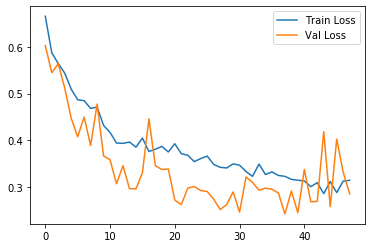

In [19]:
# Generates line plot for loss.
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend();

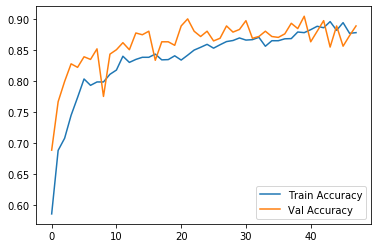

In [20]:
# Generates line plot for accuracy.
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend();

## Evaluate

In [21]:
# Evaluate model on test data.
score = model.evaluate(validation_generator,
                       verbose=1)

labels = model.metrics_names

# Show model performance.
print(f'{labels[0]}: {score[0]}')
print(f'{labels[1]}: {score[1]}')

  ...
    to  
  ['...']
12/12 [==============================] - 13s 1s/step - loss: 0.2382 - accuracy: 0.9060
loss: 0.23819293330113092
accuracy: 0.9060402512550354


## Save Model

In [25]:
model.save('../finished_model.h5')